# Cellular computing with Python 3

Python is not the fastest language for computations.
Coming from Java world it was obvious for me that Python could not compete with compiled language like Java or C++ for cellular computing.
Cellular computing supposes the interaction of a lot of cell in a localized way: with a reduced amount of neighbors.
In Java you would take an array and loop over it with an update function.
But in Python the first rule if you want to have reasonable performance is: never loop over an array.
That is why we need to use array libraries like numpy to perform vectorized computations.


## Cellular automata
Let us have a look with the well known Conway's game of life cellular automata.
First approach: we try a loop like we would do in Java


In [2]:
import numpy as np

In [3]:
class GameOfLife():
    """
    Simple class to hold the state of the cellular automata
    """
    def __init__(self,shape):
        self.shape = shape
        self._pointer = False #pointer to current buffer
        self._buffers = [self._new_buffer(),self._new_buffer()]
    
    def reset(self):
        """
        re initialization of the buffers
        """
        self._buffers = [self._new_buffer(),self._new_buffer()]
        
    def _new_buffer(self):
        return np.zeros(self.shape)
    
    def set(self,array):
        self._buffers[int(self._pointer)][...] = array
        
    def get(self):
        return self._buffers[int(self._pointer)]
        
    def run(self,nbIteration=1):
        for i in range(nbIteration):
            self.array = self._step(self._buffers[int(self._pointer)],self._buffers[int(not(self._pointer))])
            self._pointer = not(self._pointer)
        
    def _step(self,X,Y):
        for i in range(1,X.shape[0]-1):
            for j in range(1,X.shape[1]-1):
                
                # Count neighbors
                N = (X[i-1,j-1] + X[i-1,j] + X[i-1,j+1] +
                     X[i  ,j-1]            + X[i  ,j+1] +
                     X[i+1,j-1] + X[i+1,j] + X[i+1,j+1])

                # Apply rules
                state = X[i,j]
                if state:
                    if((N==2) | (N==3)):
                        newState = 1
                    else:
                        newState = 0
                else:
                    if N == 3:
                        newState = 1
                    else:
                        newState = 0
                             
                
                #Update new array
                Y[i,j] = newState

First, let us define a testing framework to be sure that this piece of code behave as we expect. We will start with a small test and improve it later. I use the good python package unittest.

In [4]:
import unittest
import numpy.testing as npt
import numpy as np

class GameOfLifeTest(unittest.TestCase):
    def __init__(self,methodName='test_run',gofClass=GameOfLife):
        super().__init__(methodName)
        self.gofClass = gofClass
        
    def setUp(self):
        self.shape = (6,6)
        self.uut = self.gofClass(self.shape)
        
    def test_run_it(self):
        a = np.array([
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,1,1,1,0],
                [0,1,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(self.uut.get().dtype)
        self.uut.set(a) #initialisation state
        b = np.array([
                [0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,0,1,0],
                [0,1,0,0,1,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(self.uut.get().dtype)
        
        self.uut.run(nbIteration=3)
        npt.assert_equal(self.uut.get(),b)
        
    def test_run(self):
        a = np.array([
                [0,0,0,0,0,0],
                [0,0,0,0,0,0],
                [0,0,1,1,1,0],
                [0,1,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(self.uut.get().dtype)
        self.uut.set(a) #initialisation state
        b = np.array([
                [0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,0,1,0],
                [0,1,0,0,1,0],
                [0,0,1,0,0,0],
                [0,0,0,0,0,0]
            ]).astype(self.uut.get().dtype)
        
        self.uut.run()
        npt.assert_equal(self.uut.get(),b)
        self.uut.run()
        npt.assert_equal(self.uut.get(),a)
        self.uut.run()
        npt.assert_equal(self.uut.get(),b)

Of course it is not enough to make a good test (we will have to take care of the border broblem at some point) but it is a good start. I used this pattern because it is one of the simplest oscillator of the game of life. If nothing disturb it, it will oscilate between states a and b forever.
This test will be usefull for every upgrade of the GameOfLife class. Every time we want to modify a method, we can then run the test to assert that the behaviour is still the same.

I will probably have an occasion to insist on the difference between parallel assynchronous computations. It is a vast subject. But as we want to simulate hardware implementation and as common hardware work in parallel we perform parallel computations.

That is why I introduced the "new array" $Y$ to write the result, while I was looping on the "old array" $X$. 

In [5]:
def runGOFTest(gofClass):
        suite = unittest.TestSuite()
        suite.addTest(GameOfLifeTest(gofClass=gofClass))
        suite.addTest(GameOfLifeTest(methodName='test_run_it',gofClass=gofClass))
        unittest.TextTestRunner().run(suite)
runGOFTest(GameOfLife)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


In [102]:
uut = GameOfLife((1000,1000))
%timeit uut.run(nbIteration=10)

AttributeError: 'GameOfLife' object has no attribute 'iterate'

The execution time is unbearably long. Looping is not an option.
We have to use the full power of numpy by vectorizing the compuations. Vectorizing is not obvious when it is the first time that you face this problem. The idea is to avoid the loop by using the optimized functions of numpy.
For instance here we want to count the number of neighbors alive for each cell. Instead of looping over each cell we can simply add shifted version of the array to each other thus obtainig the same result. And as numpy addition is optimized at a low level, the performance should increase.

In [6]:
class GameOfLifeVect(GameOfLife):
    def _step(self,X,Y):
        # Count neighbors
        N = (X[0:-2,0:-2] + X[0:-2,1:-1] + X[0:-2,2:] +
             X[1:-1,0:-2] +                X[1:-1,2:] +
             X[2:  ,0:-2] + X[2:  ,1:-1] + X[2:  ,2:])
        # Apply rules 
        birth = (N==3) & (X[1:-1,1:-1]==0) 
        survive = ((N==2) | (N==3)) & (X[1:-1,1:-1]==1) 
        #reset the cells
        Y[...] = 0
        y = Y[1:-1,1:-1]
        #switch on the cells with the rules boolean array
        y[birth | survive] = 1

After a run with the same parameters, we have an improvement of factor 100.

In [7]:
uut = GameOfLifeVect((1000,1000))
%timeit uut.run(nbIteration=10)

1 loop, best of 3: 356 ms per loop


   And here we see the usefulness of the unit testing. By runing the test with the update GameOfLife class, we assert that its computations are still valid.

In [8]:
runGOFTest(GameOfLifeVect)

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


Now can we improve it. Well the obvious answer for someone working at lower level would be to change the type of the array. Indeed the default type of the Numpy array is float64. It is a bit crazy to compute the game of life on such big cells. Let us try to reduce it.

In [9]:
class GameOfLifeUint8(GameOfLifeVect):
    def _new_buffer(self):
        return np.zeros(self.shape,dtype=np.uint8)
    

uut = GameOfLifeUint8((1000,1000))
runGOFTest(GameOfLifeUint8)
%timeit uut.run(nbIteration=10)

..

10 loops, best of 3: 34.5 ms per loop



----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


Reducing the data size improves the speed by a factor 10. But besides the speed, the logic of the approach is important as well. As we want to simulate the hardware for cellular computing it would be weird (to say the least) to use float64 numbers.

You may think that for this specific automata, boolean array would actually be even better. Indeed the cells have a binary state dead or alive. Thus there is no need of the 256 states allowed by the int8.
However boolean array manipulation is more constraning for operations: additions are not supported. Hence we need to convert the array from boolean to int8.

In [10]:
class GameOfLifeBool(GameOfLife):  
    def _new_buffer(self):
        return np.zeros(self.shape,dtype=np.bool_)
        
        
    def _step(self, X,Y):
        X_int = X.astype(np.uint8) #old array converted into uint
        # Count neighbors
        N = (X_int[0:-2,0:-2] + X_int[0:-2,1:-1] + X_int[0:-2,2:] +
             X_int[1:-1,0:-2] +                    X_int[1:-1,2:] +
             X_int[2:  ,0:-2] + X_int[2:  ,1:-1] + X_int[2:  ,2:])
        # Apply rules 
        birth = (N==3) & (~X[1:-1,1:-1]) 
        survive = ((N==2) | (N==3)) & (X[1:-1,1:-1]) 
        #reset the cells
        Y[...] = 0
        #switch on the cells with the rules boolean array
        Y[1:-1,1:-1] = birth | survive
                    

In [11]:
uutBool = GameOfLifeBool((1000,1000))
runGOFTest(GameOfLifeBool)
%timeit uutBool.run(nbIteration=10)

..

10 loops, best of 3: 34.9 ms per loop



----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


In [12]:
uutBool = GameOfLifeBool((10000,10000))
%timeit uutBool.run(nbIteration = 10)

1 loop, best of 3: 7.31 s per loop


The speed increase is not amazing but it is more satisfying. Now let us use matplotlib to visualize the cellular automata.

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

In [127]:
def plotArray(array):
    plt.imshow(np.copy(array),cmap='gray_r')
    
def plotIterations(gof,nbIteration=1):
    gof.set(np.random.random(gof.shape) < 0.5)
    for i in range(nbIteration):
        if i != 0:
            gof.run()
        plt.subplot(100 + nbIteration*10+i+1)
        plotArray(uut.get())
        plt.xticks([])
        plt.yticks([])

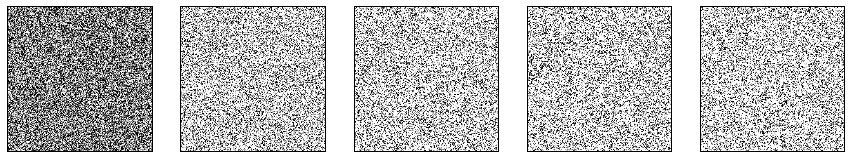

In [128]:
shape = (500,500)
uut = GameOfLifeBool(shape)
plotIterations(uut,5)